In [10]:
import ast
import base64
import io
import json
import operator
import os
import re
import sqlite3
import uuid
from datetime import datetime
from pprint import pprint
from typing import Annotated, Any, Dict, Literal, Optional, TypedDict

import dotenv
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import seaborn as sns
from langchain.tools import ToolRuntime, tool
from langchain_core.messages import (
    AIMessage,
    AnyMessage,
    HumanMessage,
    SystemMessage,
    ToolCall,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph, add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command
from langsmith import Client
from pydantic import BaseModel, Field
from sqlalchemy import create_engine, text

dotenv.load_dotenv()
API_KEY = os.getenv("OPENROUTER_API_KEY")
BASE_URL = os.getenv("API_BASE_URL")
MODEL_NAME = "qwen/qwen3-coder-30b-a3b-instruct"  # os.getenv("MODEL_NAME")
LLM = ChatOpenAI(model=MODEL_NAME, base_url=BASE_URL, api_key=API_KEY)
ls_client = Client()

LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")

DB_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "database": "user_db",
    "user": "user",
    "password": "user",
}

### Agent state

In [121]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]  # История сообщений LLM
    iteration: int
    max_iterations: int
    charts: list[str]
    is_request_valid: bool
    needs_clarification: bool

In [122]:
DB_PROMPT = """
СУБД: PostgreSQL 16
Тематика данных: пациенты, их диагнозы, рецепты и медикаменты в разрезе районов Санкт-Петербурга (СПб) и Ленинградской области (ЛО).

**Особенности данных, обязательно учитывай их при построении SQL запросов:**
- ВСЕ текстовые поля приведены к нижнему регистру, включая коды МКБ и торговые названия препаратов.
- Пол пациента: 'м' (мужчина), 'ж' (женщина).
- В таблице явно представлены регионы: 'санкт-петербург', 'ленинградская область'.
- Районы ЛО: ['колпино', 'ломоносов', 'сестрорецк', 'петродворец', 'павловск', 'пушкин', 'красное село', 'металлострой', 'зеленогорск', 'горелово'].
- Районы СПб: ['пушкинский', 'выборгский', 'калининский', 'приморский', 'московский', 'кронштадтский', 'красносельский', 'кировский', 'адмиралтейский', 'фрунзенский', 'невский', 'красногвардейский', 'василеостровский', 'центральный', 'петроградский', 'курортный', 'колпинский', 'петродворцовый'].
- Центральные районы СПб: ['адмиралтейский', 'василеостровский', 'центральный', 'петроградский'].


**DDL схема базы данных:**
```sql
-- Пациенты
CREATE TABLE patients (
    id INTEGER PRIMARY KEY,
    дата_рождения DATE,
    пол VARCHAR(10),
    район_проживания VARCHAR(100),
    регион VARCHAR(100)
);

-- Диагнозы
CREATE TABLE diagnoses (
    код_мкб VARCHAR(20) PRIMARY KEY,
    название_диагноза TEXT,
    класс_заболевания TEXT
);

-- Медикаменты
CREATE TABLE medication (
    код_препарата INTEGER PRIMARY KEY,
    дозировка VARCHAR(100),
    торговое_название VARCHAR(100),
    стоимость FLOAT,
    мета_информация VARCHAR(200)
);

-- Рецепты
CREATE TABLE recipes (
    дата_рецепта DATE,
    код_диагноза VARCHAR(20),
    код_препарата INTEGER,
    id_пациента INTEGER,
    FOREIGN KEY (id_пациента) REFERENCES patients(id),
    FOREIGN KEY (код_диагноза) REFERENCES diagnoses(код_мкб),
    FOREIGN KEY (код_препарата) REFERENCES medication(код_препарата)
);
```
"""

In [153]:
def get_db_engine():
    url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
    return create_engine(url)


class ExecuteSQLInput(BaseModel):
    query: str = Field(description="SQL query to execute")


@tool(args_schema=ExecuteSQLInput)
def execute_sql_tool(query: str) -> list[dict[str, Any]] | str:
    """Выполняет SQL запрос и возвращает результат как список словарей."""
    try:
        engine = get_db_engine()
        if "limit" not in query.lower():
            query = query.rstrip(";") + " LIMIT 25;"

        with engine.connect() as conn:
            df = pd.read_sql(text(query), conn)

        if df.empty:
            return "Query executed successfully but returned no results."

        return df.to_dict(orient="records")
    except Exception as e:
        return f"SQL Error: {str(e)}"


class PlotChartInput(BaseModel):
    df: list[dict] | str = Field(description="DataFrame data as list of dicts")
    chart_type: str = Field(description="Type of chart: barplot, lineplot, scatterplot")
    x: str = Field(description="Column name for x-axis")
    y: str = Field(description="Column name for y-axis")
    hue: Optional[str] = Field(default=None, description="Column name for hue (optional)")
    title: Optional[str] = Field(default=None, description="Custom title for the chart (optional)")
    xlabel: Optional[str] = Field(default=None, description="Label for the x-axis (optional)")
    ylabel: Optional[str] = Field(default=None, description="Label for the y-axis (optional)")


@tool(args_schema=PlotChartInput)
def plot_chart_tool(
    df: list[dict],
    chart_type: str,
    x: str,
    y: str,
    hue: str = None,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None,
) -> str:
    """Строит график и возвращает путь к файлу."""
    try:
        if not df:
            return "No data to plot."

        df = pd.DataFrame(ast.literal_eval(df)) if isinstance(df, str) else pd.DataFrame(df)

        plt.figure(figsize=(10, 6))

        if chart_type == "barplot":
            sns.barplot(data=df, x=x, y=y, hue=hue)
        elif chart_type == "lineplot":
            sns.lineplot(data=df, x=x, y=y, hue=hue)
        elif chart_type == "scatterplot":
            sns.scatterplot(data=df, x=x, y=y, hue=hue)
        else:
            return f"Unsupported chart type: {chart_type}"

        title = title if title is not None else f"{chart_type}_{x}_by_{y}"
        plt.title(title)

        if xlabel:
            plt.xlabel(xlabel)
        if ylabel:
            plt.ylabel(ylabel)

        plt.xticks(rotation=45, ha="right")

        ax = plt.gca()
        xlabels = ax.get_xticklabels()
        new_labels = [
            label.get_text()[:30] + "..." if len(label.get_text()) > 30 else label.get_text()
            for label in xlabels
        ]
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(new_labels, rotation=45, ha="right")

        plt.tight_layout()

        plt.savefig(f"plot_{title}.png")
        plt.close()
        return f"Chart {chart_type} (x={x}, y={y}) generated successfully."
    except Exception as e:
        return f"Plotting Error: {str(e)}"

In [141]:
SYS_PROMPT = """Ты агент аналитик. Твоя задача - помогать пользователю анализировать данные в базе данных PostgreSQL,
используя SQL запросы и визуализации графиков.


## Правила работы:
1. Планируй свои действия заранее, прежде чем что-то делать.
2. Ты можешь модицицировать план в процессе выполнения при необходимости.
3. План должен включать визуализации, если они помогут лучше выполнить запрос,
даже если пользователь явно не просил их;
4. Ты не можешь получать *сырые данные без агрегации, т.к. данные слишком объёмные.
Используй сколь угодно сложный SQL вопрос -- но не допускай получение объёмных сырых данных.
5. Используй нижний регистр для всех текстовых значений (в т.ч. коды МКБ-10) в SQL запросах.
6. Используй регулярные выражения для поиска и фильтрации текстовых данных.

*Сырые данные без агрегации -- это когда ты просто выбираешь все строки из таблицы без группировки или фильтрации:
получение всех пациентов без какой-либо агрегации по возрасту, полу, району и т.д. Например,
`SELECT * FROM patients WHERE регион = 'санкт-петербург';`


## Данные о базе:
{db_prompt}


## Cтруктура МКБ-10 при работе с диагнозами, кодами МКБ и поиском заболеваний:
- Некоторые инфекционные и паразитарные болезни — A00–B99  
- Новообразования — C00–D48  
- Болезни крови и кроветворных органов; нарушения иммунного механизма — D50–D89  
- Болезни эндокринной системы, питания и обмена веществ — E00–E90  
- Психические расстройства и расстройства поведения — F00–F99  
- Болезни нервной системы — G00–G99  
- Болезни глаза — H00–H59  
- Болезни уха и сосцевидного отростка — H60–H95  
- Болезни системы кровообращения — I00–I99  
- Болезни органов дыхания — J00–J99  
- Болезни органов пищеварения — K00–K93  
- Болезни кожи и подкожной клетчатки — L00–L99  
- Болезни костно-мышечной системы и соединительной ткани — M00–M99  
- Болезни мочеполовой системы — N00–N99  
- Беременность, роды и послеродовый период — O00–O99  
- Состояния перинатального периода — P00–P96  
- Врожденные аномалии и хромосомные нарушения — Q00–Q99  
- Симптомы и отклонения, не классифицированные в других рубриках — R00–R99  
- Травмы, отравления и последствия внешних воздействий — S00–T98  
- Внешние причины заболеваемости и смертности — V01–Y98  
- Факторы, влияющие на обращение в медучреждения — Z00–Z99  
- Коды для особых целей — U00–U85


## Настоящее время и дата (DD-MM-YYYY HH:MM:SS): {current_datetime}
"""

In [150]:
ROUTER_PROMPT = """Ты агент-аналитик данных. Проанализируй запрос пользователя и определи, достаточно ли
в нём информации для выполнения анализа.

Контекст базы данных:
{db_prompt}

Настоящее время и дата (DD-MM-YYYY HH:MM:SS): {current_datetime}

Проверь валидность вопроса по следующим критериям:
1. Запрос относится к тематике базы данных (пациенты, диагнозы, рецепты, медикаменты в СПб и ЛО)?
2. Запрос не требует получения сырых данных без агрегации?
3. Запрос не выходит за рамки возможностей базы данных (т.е. не требует данных, которых нет в базе)?

Проверь полноту и конкретику запроса по следующим критериям:
1. Достаточно ли конкретики (временной период, география, категории)?
2. Понятен ли запрос без дополнительных уточнений?
3. Нет ли неоднозначности в терминах?

Действуй по следующим правилам:
1. Если запрос не валиден, верни is_request_valid=False,
2. Если запрос требует уточнений - верни is_request_valid=True, needs_clarification=True и
сформулируй 3 исправленных запроса и предложи их пользователю.
3. Если запрос не требует уточнений и понятен - верни is_request_valid=True, needs_clarification=False.
4. Отвечай кратко и по существу.

Например:
Чем болеют в городе? --> needs_clarification=True, is_request_valid=True, new_request=None, 3 варианта уточнения:
Возможно вы имели ввиду:
1. Топ-5 заболеваний в СПб?
2. Топ-5 заболеваний в СПб и ЛО?
3. Топ-5 заболеваний в центральных районах СПб?
"""

In [151]:
class RouterOutput(BaseModel):
    is_request_valid: bool = Field(description="True если запрос валиден и понятен, иначе False")
    needs_clarification: bool | None = Field(
        description="True если требуется уточнение, иначе False"
    )
    your_response: Optional[str] = Field(
        default=None,
        description="Твое уточнение, если needs_clarification равно True. Иначе объяснение почему is_request_valid равно False.",
    )


def router(state: AgentState) -> AgentState:
    """Определяет, нужно ли запросить уточнение у пользователя/валиден ли запрос."""
    messages = state["messages"]
    sys_msg = SystemMessage(
        content=ROUTER_PROMPT.format(
            db_prompt=DB_PROMPT,
            current_datetime=datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        )
    )
    llm_with_structured_output = LLM.with_structured_output(RouterOutput)
    response = llm_with_structured_output.invoke([sys_msg] + messages)

    your_response = response.your_response
    if your_response is None:
        your_response = "Запрос валиден и не требует уточнений."

    return {
        **state,
        "needs_clarification": response.needs_clarification,
        "is_request_valid": response.is_request_valid,
        "messages": messages + [AIMessage(content=your_response)],
    }


def route_after_router(
    state: AgentState,
) -> Literal["needs_clarification", "continue", "invalid_request"]:
    if not state["is_request_valid"]:
        return "invalid_request"
    if state["needs_clarification"]:
        return "needs_clarification"
    return "continue"


def get_human_feedback(state: AgentState) -> AgentState:
    """Запрашивает уточнение у пользователя."""
    clarification_prompt = state["messages"][-1].content
    feedback = input(clarification_prompt + "\n")
    human_msg = HumanMessage(content=feedback)
    return {"messages": state["messages"] + [human_msg]}


sys_msg = SystemMessage(
    content=SYS_PROMPT.format(
        db_prompt=DB_PROMPT, current_datetime=datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    )
)

tools = [execute_sql_tool, plot_chart_tool]
llm_with_tools = LLM.bind_tools(tools)


def assistant(state: AgentState) -> AgentState:
    messages = state["messages"]
    response = llm_with_tools.invoke([sys_msg] + messages)
    return {
        **state,
        "messages": messages + [response],
        "iteration": state["iteration"] + 1,
    }


def should_continue(state: AgentState) -> Literal["go", "stop"]:
    last_msg = state["messages"][-1]
    if isinstance(last_msg, AIMessage) and state["iteration"] >= state["max_iterations"]:
        return "stop"
    if isinstance(last_msg, AIMessage) and last_msg.tool_calls:
        return "go"
    return "stop"


SUMMARIZER_PROMPT = """
Ты агент суммаризатор. Изучи историю сообщений, итоги проделанной работы и ответь на вопрос пользователя кратко и по существу.
Сегодня (DD-MM-YYYY HH:MM:SS) {current_datetime}.
"""


def summarizer(state: AgentState) -> AgentState:
    messages = state["messages"]
    sys_msg = SystemMessage(
        content=SUMMARIZER_PROMPT.format(
            current_datetime=datetime.now().strftime("%d-%m-%Y %H:%M:%S")
        )
    )
    summary = LLM.invoke([sys_msg] + messages)
    return {**state, "messages": messages + [summary]}

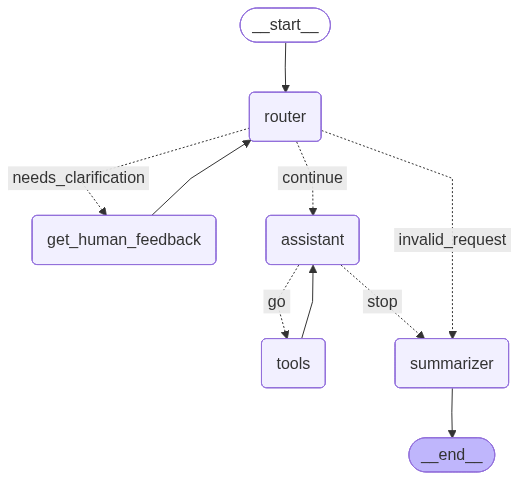

In [152]:
builder = StateGraph(AgentState)

builder.add_node("router", router)
builder.add_node("get_human_feedback", get_human_feedback)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("summarizer", summarizer)

builder.add_edge(START, "router")
builder.add_conditional_edges(
    "router",
    route_after_router,
    {
        "needs_clarification": "get_human_feedback",
        "continue": "assistant",
        "invalid_request": "summarizer",
    },
)
builder.add_edge("get_human_feedback", "router")
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {
        "stop": "summarizer",
        "go": "tools",
    },
)
builder.add_edge("tools", "assistant")
builder.add_edge("summarizer", END)

graph = builder.compile()
graph

In [ ]:
final_state = graph.invoke(
    {
        "messages": [
            HumanMessage(
                content="Динамика заболеваемости среди мужчин и женщин в СПб за последние 5 лет"
            )
        ],
        "iteration": 0,
        "max_iterations": 15,
    }
)

for m in final_state["messages"]:
    m.pretty_print()

/tmp/ipykernel_90105/252629944.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


================================ Human Message =================================

Динамика заболеваемости среди мужчин и женщин в СПб за последние 5 лет
================================== Ai Message ==================================

Запрос валиден и понятен. Он относится к тематике базы данных, не требует получения сырых данных без агрегации и соответствует возможностям базы. Запрос достаточно конкретен: он указывает временной период (последние 5 лет), географию (Санкт-Петербург) и категорию (манские и женские пациенты).
================================== Ai Message ==================================

 

Для его реализации мне потребуется:
1. Определить последние 5 лет на момент текущей даты (2025 г.).
2. Сгруппировать данные по полу пациентов.
3. Отфильтровать данные по региону "санкт-петербург".
4. Сгруппировать по годам для отображения динамики.
5. Предоставить информацию о количестве диагнозов или рецептов (т.к. здесь важно определить, как мерить "заболеваемость").

Поскольку дин